In [35]:
import os
import hashlib
import shutil
import cv2
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from transformers import ViTModel, ViTImageProcessor


In [36]:
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [37]:
# Function to handle resizing
def resize_image(image, size=(224, 224)):
    """
    Resizes the image to the specified size.
    """
    return image.resize(size)

In [38]:
# Function to convert image to greyscale
def convert_to_greyscale(image):
    """
    Converts the image to greyscale.
    """
    return image.convert("L")

In [39]:
def remove_corrupt_image(image_path):
    """
    Attempts to open the image and returns True if valid, False if corrupt.
    """
    try:
        with Image.open(image_path) as img:
            img.verify()  # Verifies if the image is corrupt
        return True
    except (OSError, ValueError):
        return False

In [40]:
def process_image(image_path, new_path, size=(224, 224)):
    """
    Processes the image: resizing, converting to greyscale, and handling corrupt images.
    """
    if remove_corrupt_image(image_path):
        try:
            with Image.open(image_path) as img:
                img = img.convert("RGB")  # Convert to RGB (remove color profile)
                img = resize_image(img, size)  # Resize image
                # img = convert_to_greyscale(img)  # Convert to greyscale
                img.save(new_path)  # Save processed image
                print(f"Processed and saved {image_path}")
        except Exception as e:
            print(f"Skipping {image_path}, could not process. Error: {e}")
    else:
        print(f"Skipping {image_path}, image is corrupt.")

In [41]:
def process_images_in_directory(old_dir, new_dir, size=(224, 224)):
    """
    Processes all images in the given directory: resizing, greyscale conversion, and skipping corrupt ones.
    """
    os.makedirs(new_dir, exist_ok=True)  # Ensure the destination directory exists

    # Process all images in the old directory
    for filename in os.listdir(old_dir):
        if filename.endswith((".png", ".jpg", ".jpeg")):  # Filter image files
            old_path = os.path.join(old_dir, filename)
            new_path = os.path.join(new_dir, filename)
            process_image(old_path,  new_path, size)

In [42]:
process_images_in_directory("old_favicons","resized_favicons")

Processed and saved old_favicons/aamcooflascruces_com.png
Processed and saved old_favicons/static_flashbay_co_nz.png
Processed and saved old_favicons/www_bakertilly_se.png
Processed and saved old_favicons/www_renaultcampeche_mx.png
Processed and saved old_favicons/www_wurth_es.png
Processed and saved old_favicons/freseniuskidneycare_au.png
Processed and saved old_favicons/libs_infiniti-cdn_net.png
Processed and saved old_favicons/www_sans-sans_com_my.png
Processed and saved old_favicons/lidl-voyages_fr.png
Processed and saved old_favicons/daikin_al.png
Processed and saved old_favicons/culligantotalwater_com.png
Processed and saved old_favicons/greatplacetowork_com_vn.png
Processed and saved old_favicons/medef71_com.png
Processed and saved old_favicons/avia_ch.png
Processed and saved old_favicons/ardex_pl.png
Processed and saved old_favicons/yves-rocher_pt.png
Processed and saved old_favicons/www_renaultchiapas_com_mx.png
Processed and saved old_favicons/adra_org_pe.png
Processed and sa

In [43]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load pre-trained ResNet-50 model (without classification head)
model = models.resnet50(pretrained=True)
model = model.eval()  # Set to evaluation mode

# Remove the final fully connected layer (classification head)
model = torch.nn.Sequential(*list(model.children())[:-1])

# Define image transformation pipeline (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def extract_features(image_path):
    """Extract feature vector from an image."""
    img = Image.open(image_path).convert('RGB')  # Open image
    img = transform(img).unsqueeze(0)  # Apply transformations
    with torch.no_grad():
        features = model(img)  # Get the features from the model
    return features.flatten()  # Flatten the features to a 1D vector


In [44]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm
import os

def compute_similarity(features1, features2):
    """Compute cosine similarity between two feature vectors."""
    return cosine_similarity([features1], [features2])[0][0]

# Store features and their corresponding image paths
image_features = []
image_paths = []

# Extract features for all images with a progress bar
for filename in tqdm(os.listdir("resized_favicons"), desc="Extracting features", unit="image"):
    if filename.endswith((".png", ".jpg", ".jpeg")):
        image_path = os.path.join("resized_favicons", filename)
        features = extract_features(image_path)
        image_features.append(features)
        image_paths.append(image_path)

# Now, compare features to remove duplicates with a progress bar
threshold = 0.95  # Set a similarity threshold for near-duplicates
unique_images = []
seen_indices = set()

for i in tqdm(range(len(image_features)), desc="Comparing images", unit="image"):
    if i not in seen_indices:
        for j in range(i + 1, len(image_features)):
            similarity = compute_similarity(image_features[i], image_features[j])
            if similarity > threshold:
                seen_indices.add(j)  # Mark the duplicate image index
        unique_images.append(image_paths[i])

print(f"Found {len(unique_images)} unique images.")


Comparing images: 100%|██████████| 2474/2474 [10:49<00:00,  3.81image/s] 

Found 1048 unique images.


In [45]:
import os
import shutil

# Folder where unique images will be stored
unique_images_dir = "unique_images"

# Create the folder if it doesn't exist
os.makedirs(unique_images_dir, exist_ok=True)

# Copy the unique images to the new directory
for image_path in tqdm(unique_images, desc="Copying unique images", unit="image"):
    try:
        shutil.copy(image_path, os.path.join(unique_images_dir, os.path.basename(image_path)))
        print(f"Copied: {os.path.basename(image_path)}")
    except Exception as e:
        print(f"Error copying {os.path.basename(image_path)}: {e}")

print(f"All unique images are stored in '{unique_images_dir}'.")


Copying unique images:  26%|██▌       | 273/1048 [00:00<00:00, 2728.90image/s]

Copied: aamcooflascruces_com.png
Copied: static_flashbay_co_nz.png
Copied: www_bakertilly_se.png
Copied: www_renaultcampeche_mx.png
Copied: www_wurth_es.png
Copied: freseniuskidneycare_au.png
Copied: libs_infiniti-cdn_net.png
Copied: www_sans-sans_com_my.png
Copied: lidl-voyages_fr.png
Copied: daikin_al.png
Copied: culligantotalwater_com.png
Copied: greatplacetowork_com_vn.png
Copied: medef71_com.png
Copied: avia_ch.png
Copied: ardex_pl.png
Copied: yves-rocher_pt.png
Copied: adra_org_pe.png
Copied: synlab_com_cy.png
Copied: static_parastorage_com.png
Copied: spitexzh_ch.png
Copied: engie_de.png
Copied: aamcohemetca_com.png
Copied: subway_com_my.png
Copied: kia-gorny-eislingen_de.png
Copied: hps-guns_de.png
Copied: www_castsoftware_it.png
Copied: www_terradat_co_uk.png
Copied: bbraun_co_uk.png
Copied: image-assets_eu-2_volcanic_cloud.png
Copied: axa-assistance_pl.png
Copied: bbraun_co_in.png
Copied: mazdaofalexandria_com.png
Copied: esseskincare_nl.png
Copied: tupperware_gr.png
Copied: 

Copying unique images:  77%|███████▋  | 809/1048 [00:00<00:00, 2554.42image/s]

Copied: www_wwfcz_org.png
Copied: www_cvjm-augsburg_de.png
Copied: zhcpa_cn.png
Copied: alchemia-nova_eu.png
Copied: newson-gale_co_uk.png
Copied: dhjhkxawhe8q4_cloudfront_net.png
Copied: www_furuno_co_uk.png
Copied: cleijsen_nl.png
Copied: cinnabon-ksa_com.png
Copied: leroymerlin_co_za.png
Copied: toyotacommonwealth_com.png
Copied: mersen_jp.png
Copied: customneon_com_au.png
Copied: julis-mfr_de.png
Copied: whisky_de.png
Copied: www_engie_cl.png
Copied: www_demeter_at.png
Copied: spitex-kriens_ch.png
Copied: goliathgames_com.png
Copied: lindt_itembox_design.png
Copied: nissanmanufacturing_com.png
Copied: overheaddoorbrookfield_com.png
Copied: carglass_dk.png
Copied: img1_wsimg_com.png
Copied: rotary6450_org.png
Copied: subaru_nc.png
Copied: www_mtn_ng.png
Copied: reclique-core-waycross_s3_amazonaws_com.png
Copied: www_hennessyfunds_com.png
Copied: deo_shopeemobile_com.png
Copied: skodanews_de.png
Copied: rotary_no.png
Copied: www_hollandandbarrett_ae.png
Copied: immunospot_eu.png
Copi

Copying unique images: 100%|██████████| 1048/1048 [00:00<00:00, 2541.32image/s]

Copied: inhuntworld_com.png
Copied: www_astreitalia_it.png
Copied: lunarclient_com.png
Copied: images_tcdn_com_br.png
Copied: daikin_com_vn.png
Copied: linexcoloradosprings_com.png
Copied: apexdynamicsgermany_de.png
Copied: veka_com_sg.png
Copied: saint-gobain_com_co.png
Copied: ymca-cnw_org.png
Copied: pj_restapp_com.png
All unique images are stored in 'unique_images'.


In [46]:
from sklearn.preprocessing import StandardScaler

# Step 1: Extract features for all unique images
image_features = []
image_paths = []

for image_path in tqdm(unique_images, desc="Extracting features", unit="image"):
    features = extract_features(image_path)
    image_features.append(features)
    image_paths.append(image_path)

# Convert to NumPy array
image_features = np.array(image_features)

# Step 2: Standardize features before clustering
scaler = StandardScaler()
features_scaled = scaler.fit_transform(image_features)


Extracting features:   0%|          | 0/1048 [00:00<?, ?image/s]

Extracting features: 100%|██████████| 1048/1048 [01:47<00:00,  9.79image/s]


In [47]:
from sklearn.cluster import KMeans
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Extract features for unique images
features = [extract_features(path) for path in unique_images]

# Convert to numpy array for clustering
features_array = np.array(features)

In [48]:
from sklearn.decomposition import PCA

# Reduce to 50 dimensions, or even 2 for t-SNE/visualization
# pca = PCA(n_components=50)
# features_pca = pca.fit_transform(features_array)

# Now cluster again with KMeans
kmeans = KMeans(n_clusters=50, random_state=42)
labels = kmeans.fit_predict(features_array)


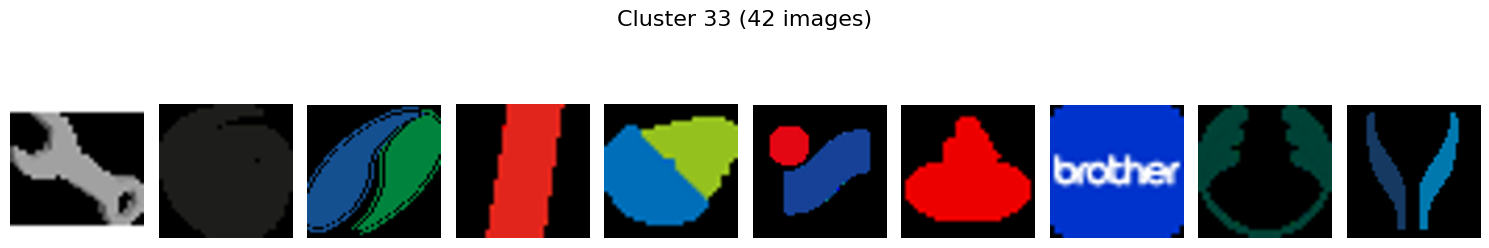

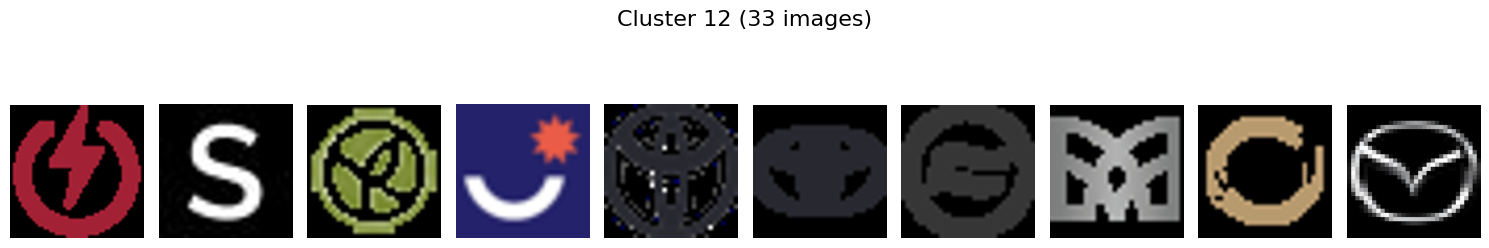

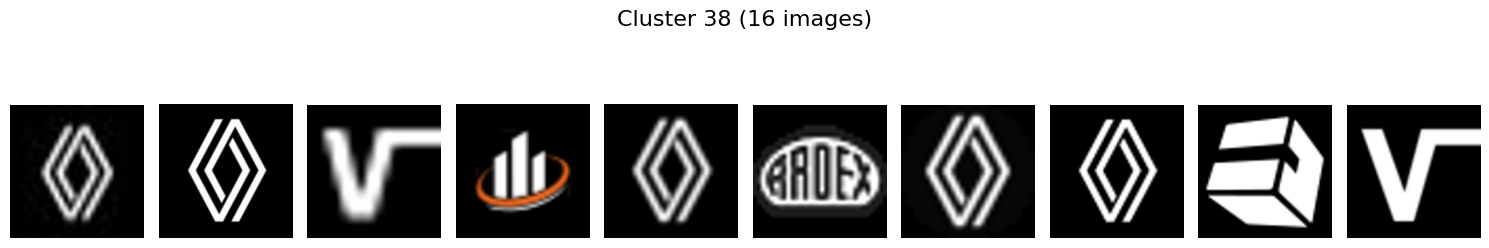

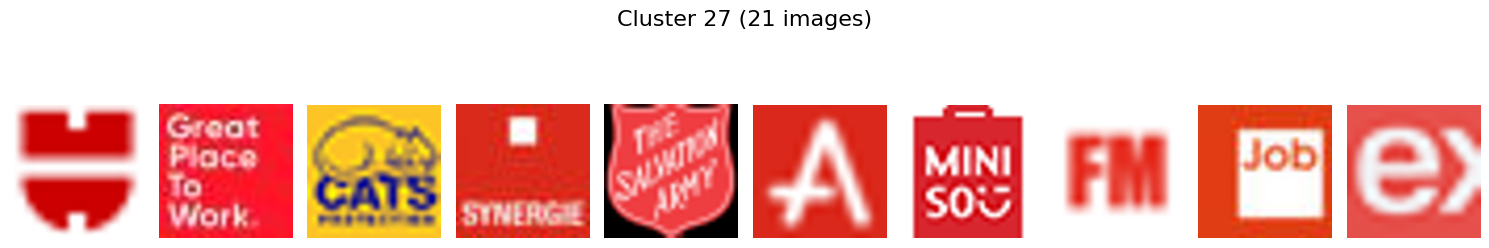

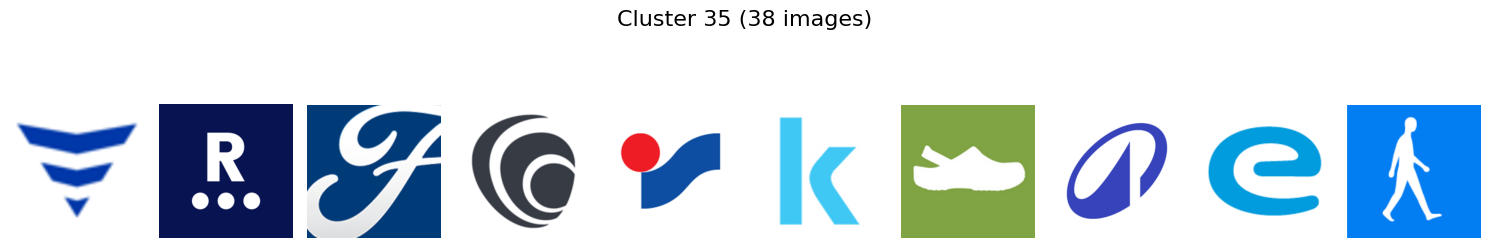

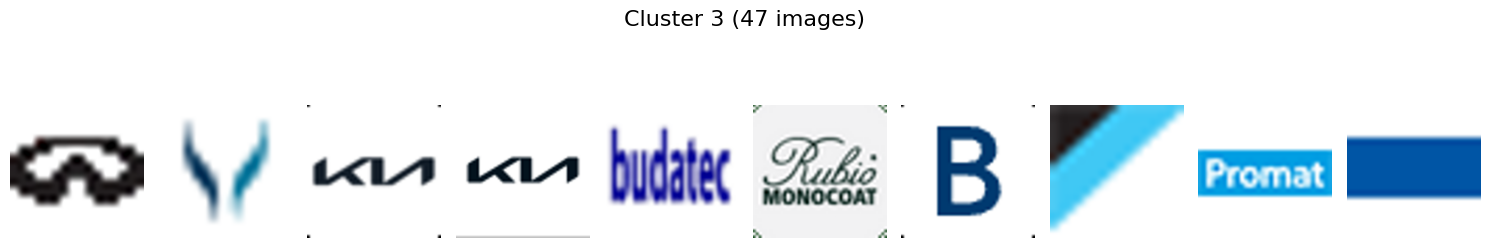

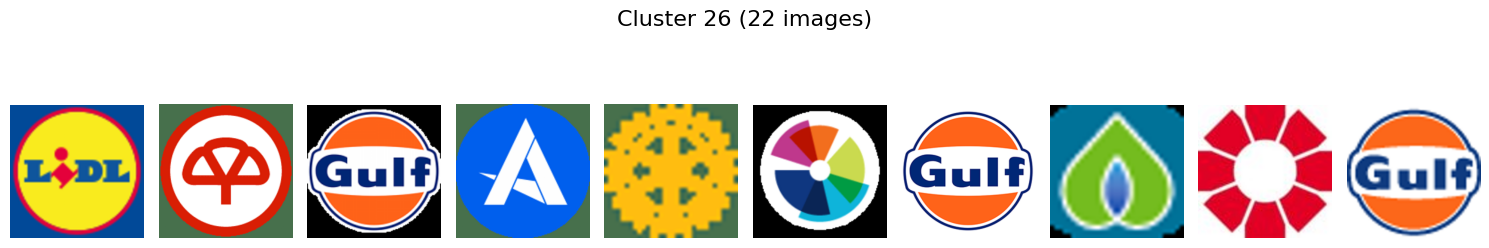

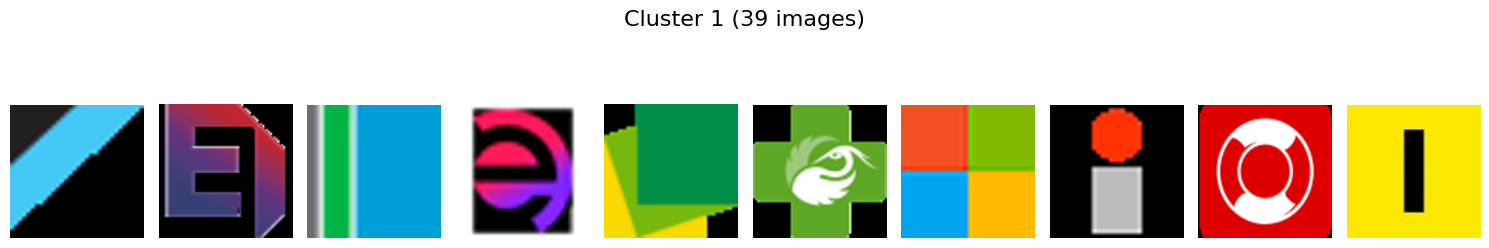

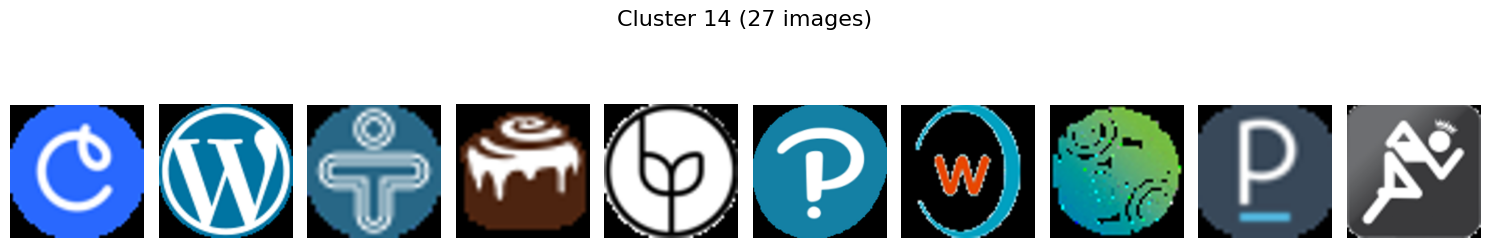

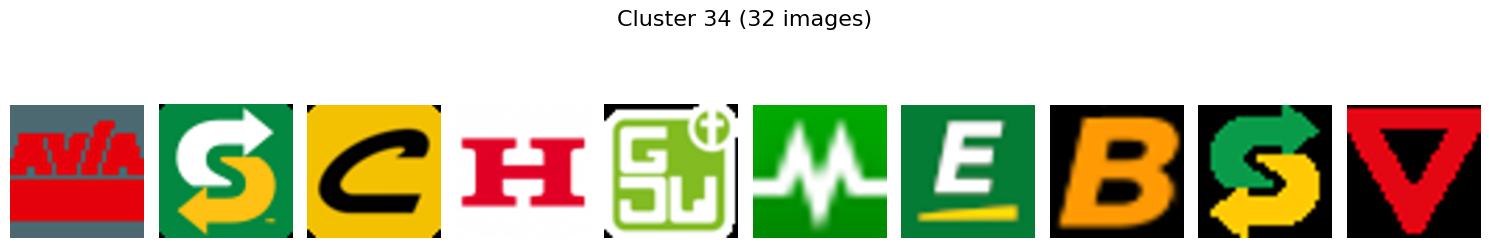

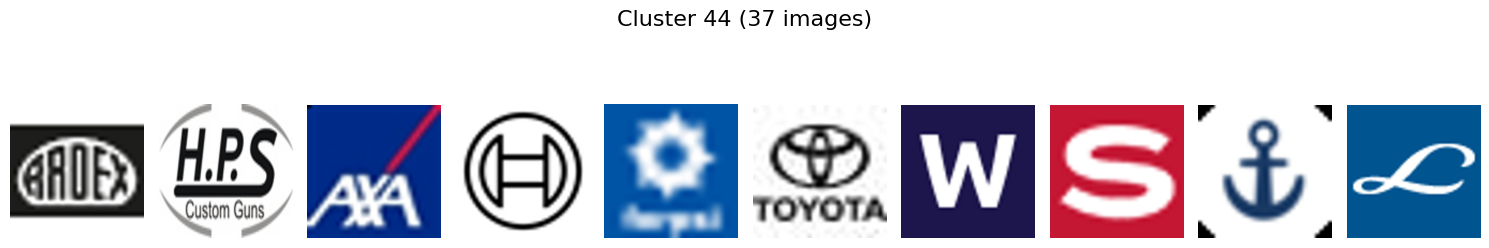

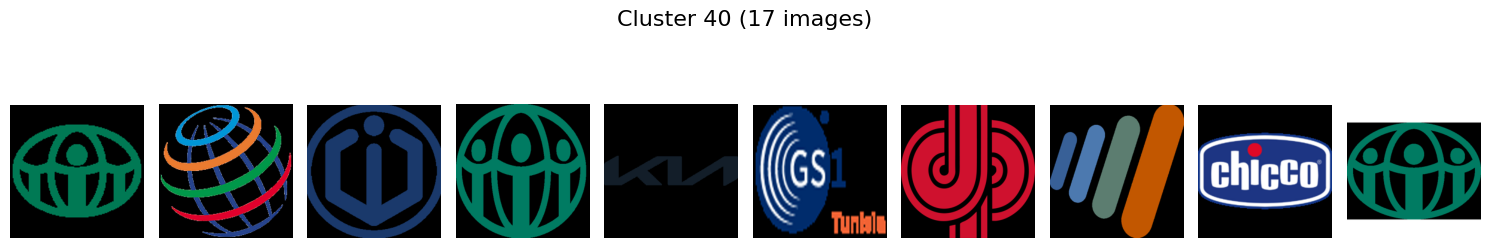

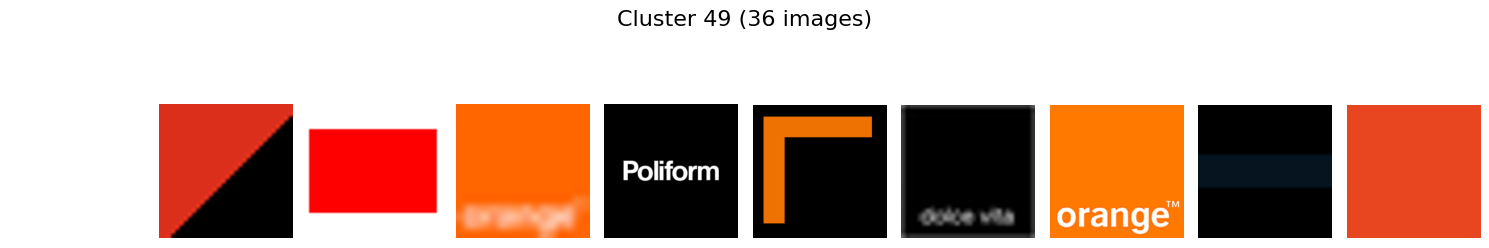

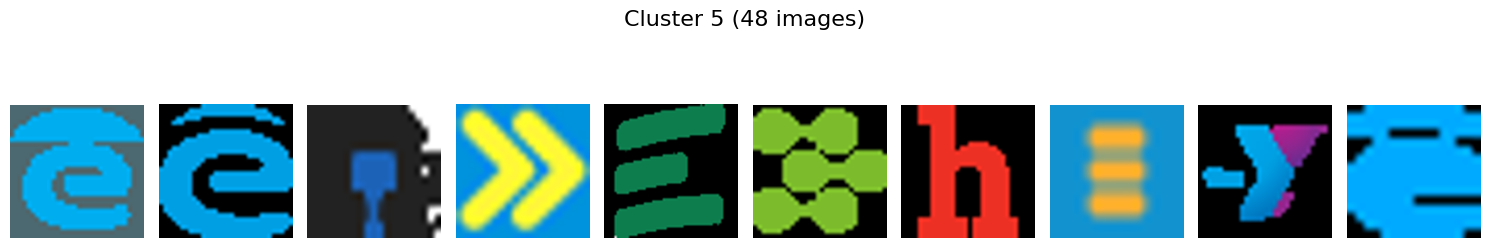

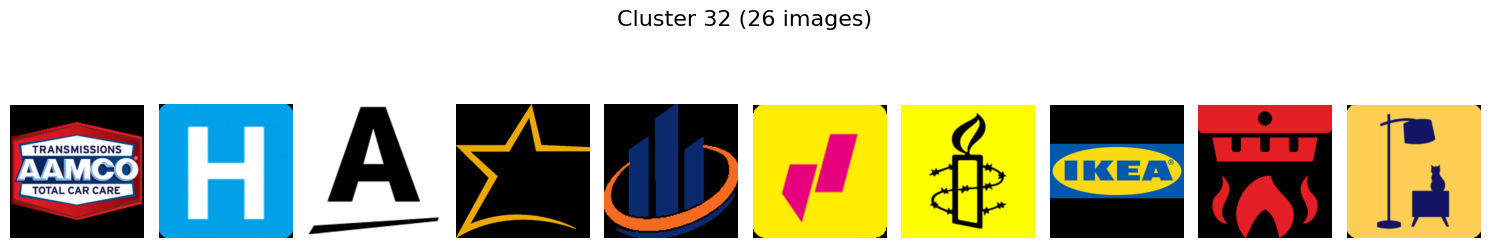

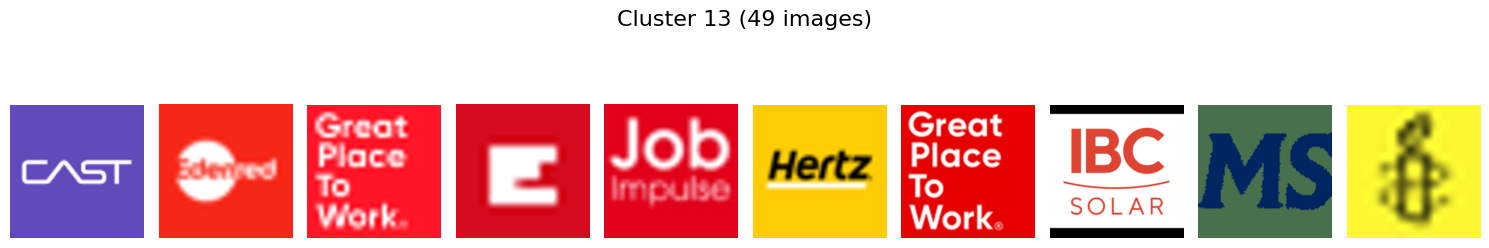

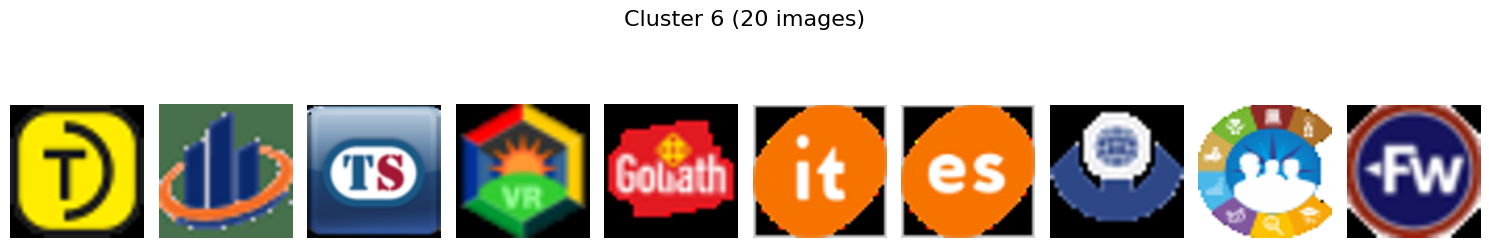

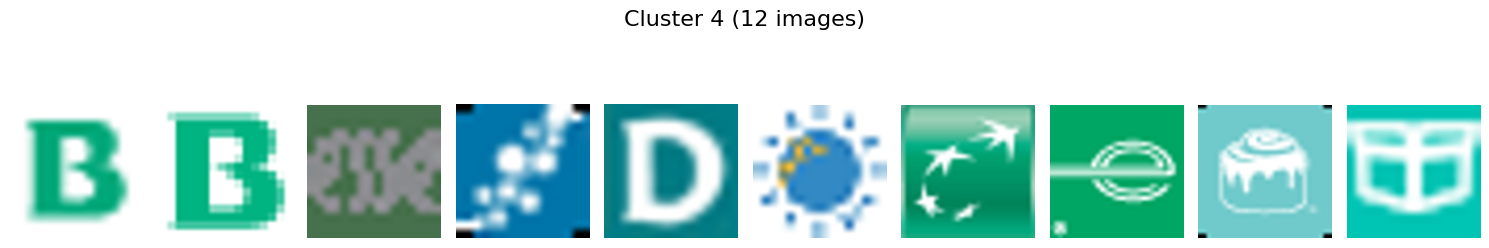

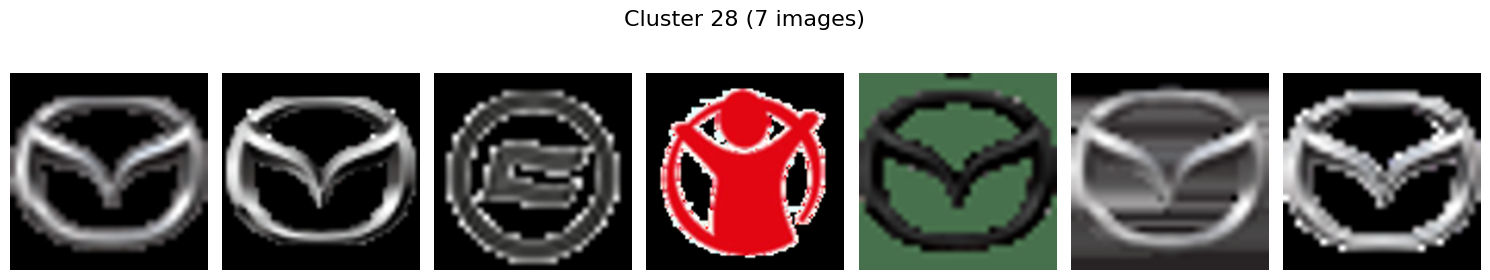

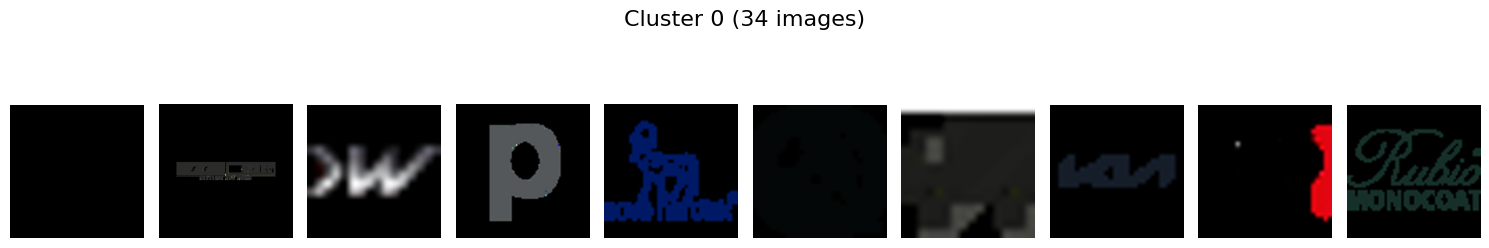

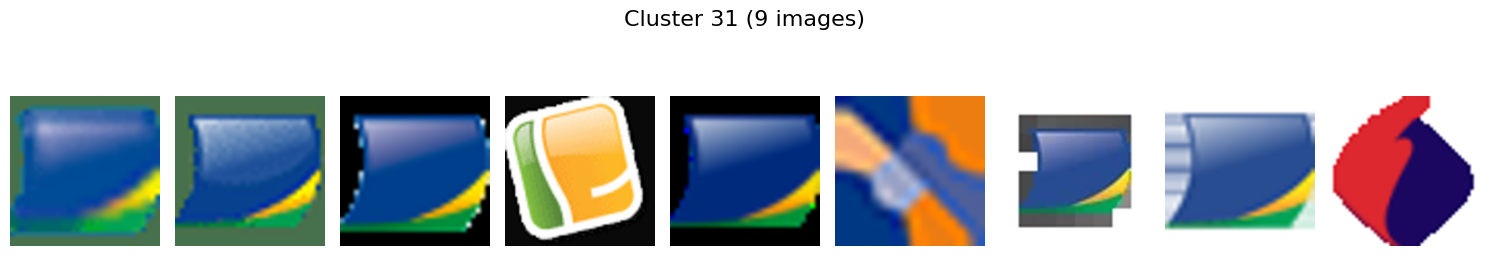

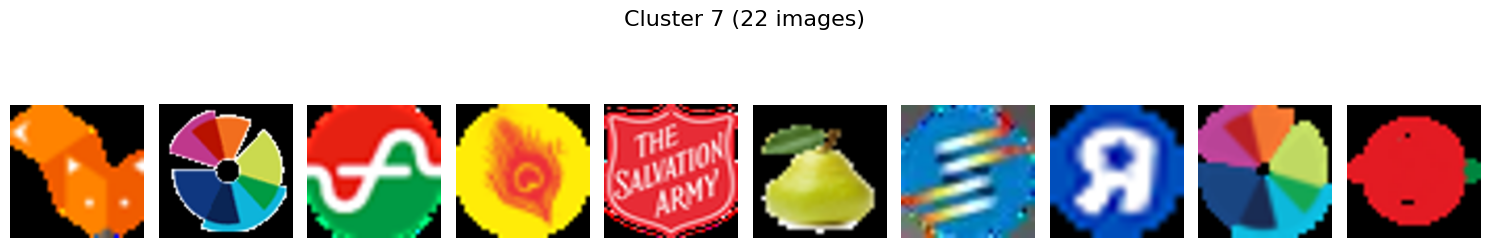

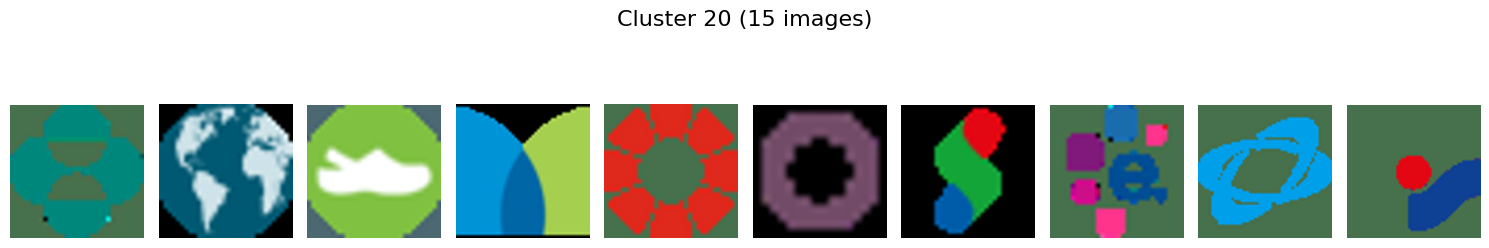

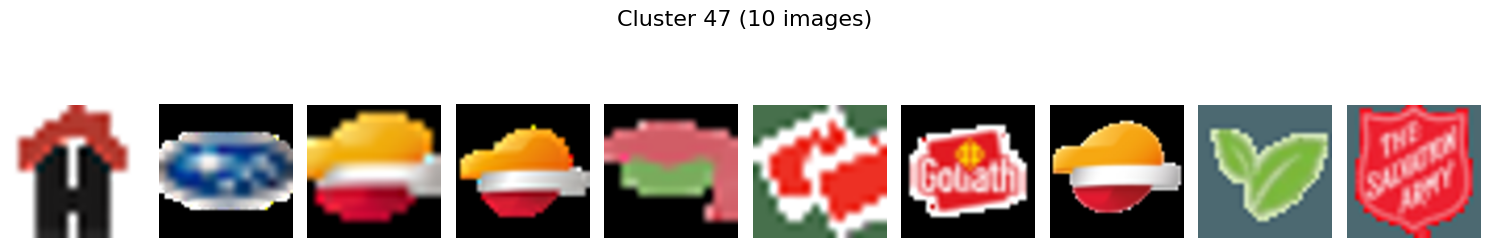

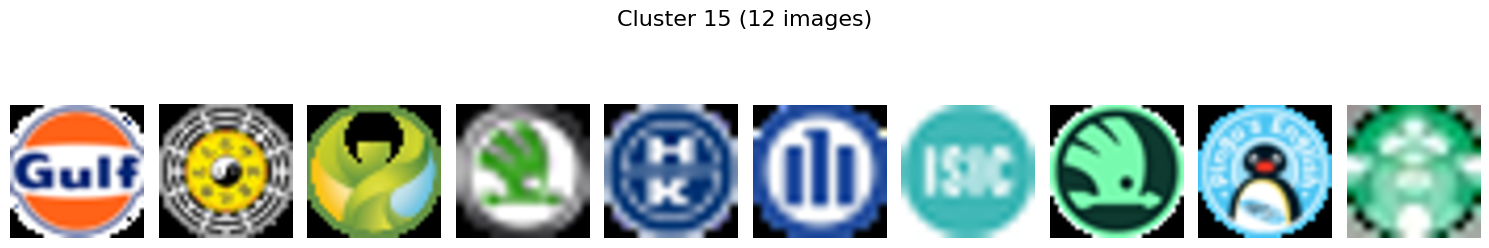

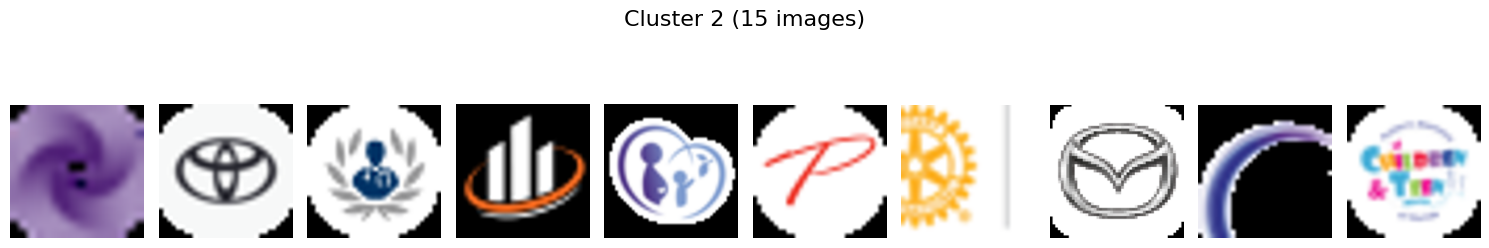

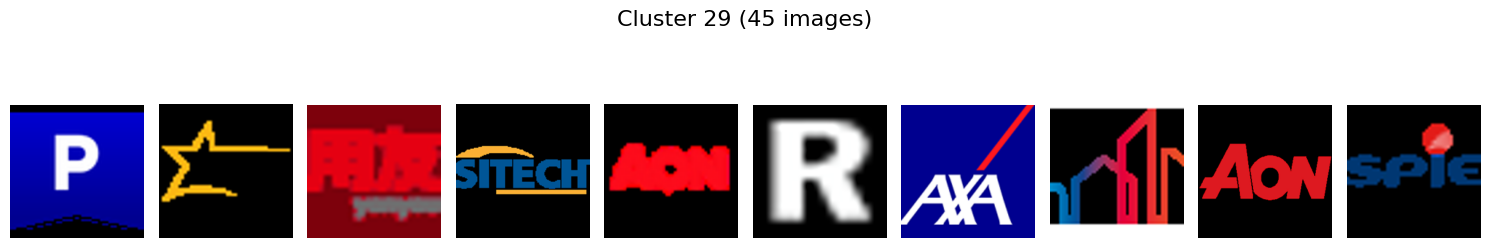

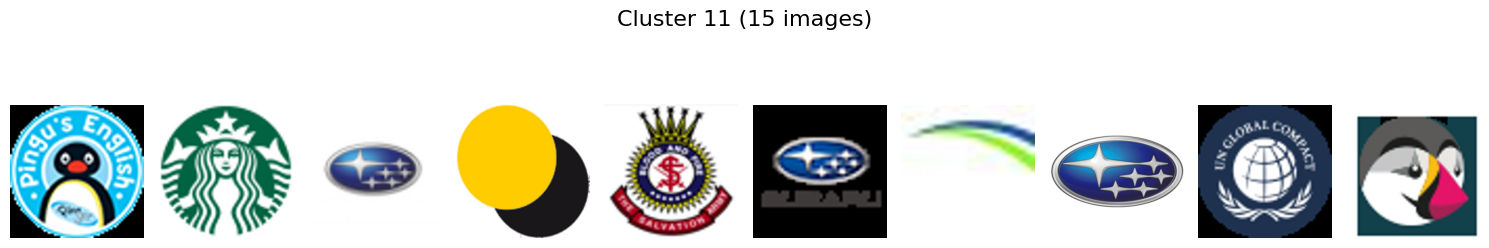

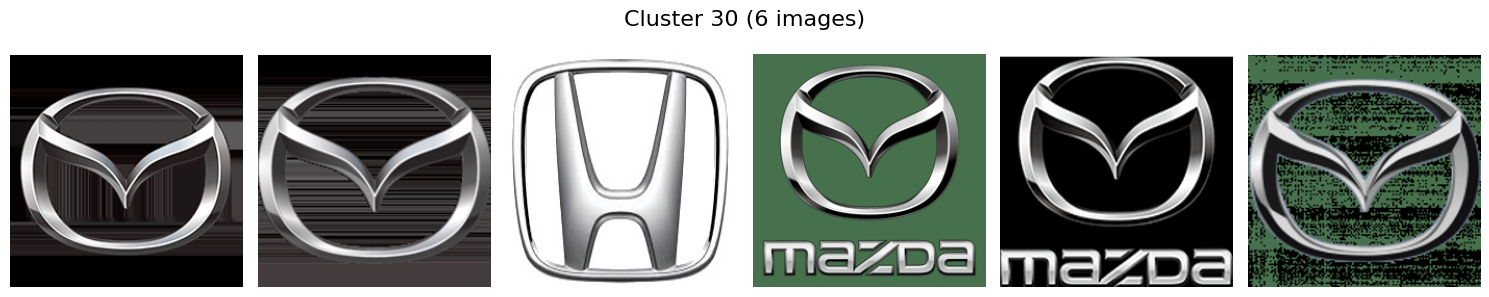

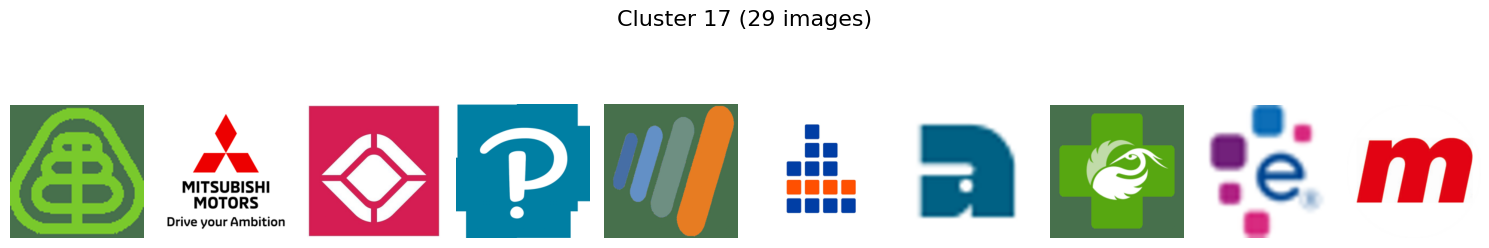

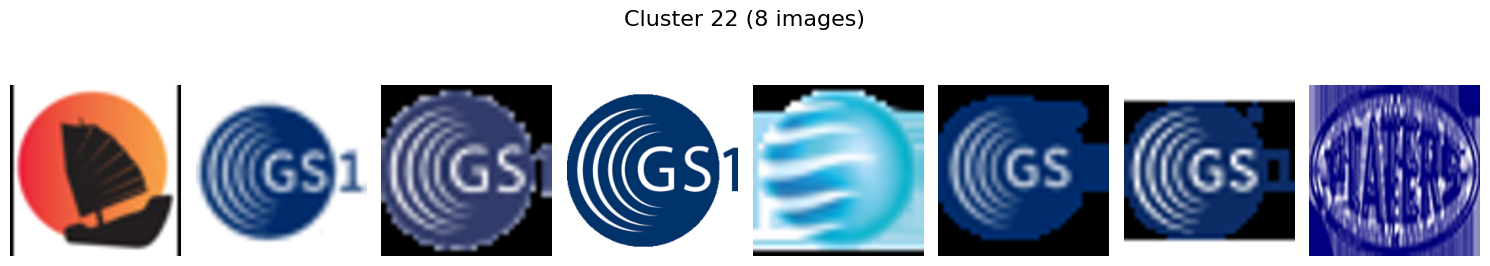

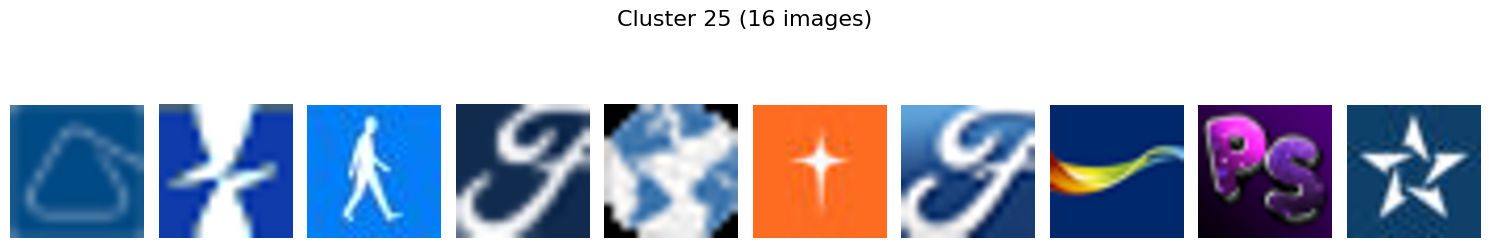

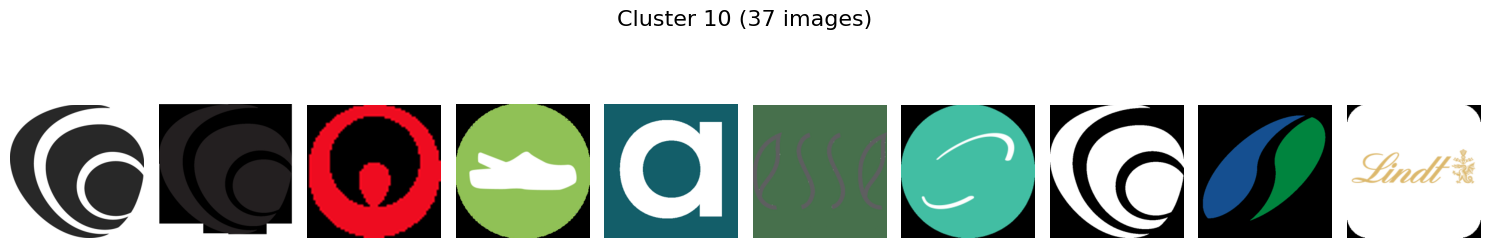

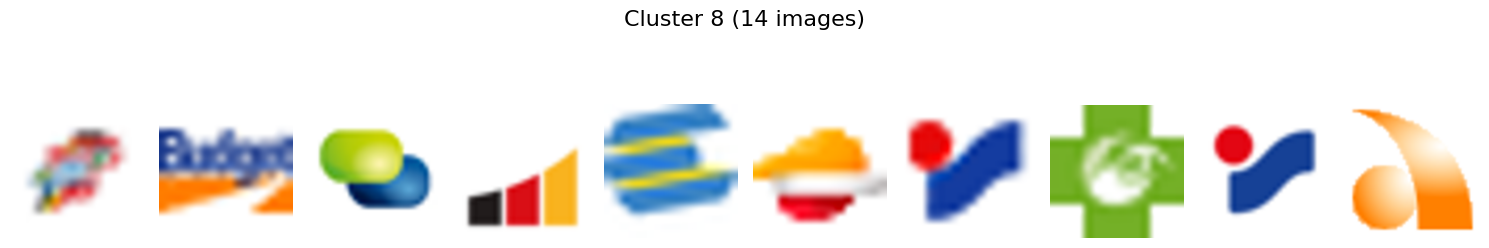

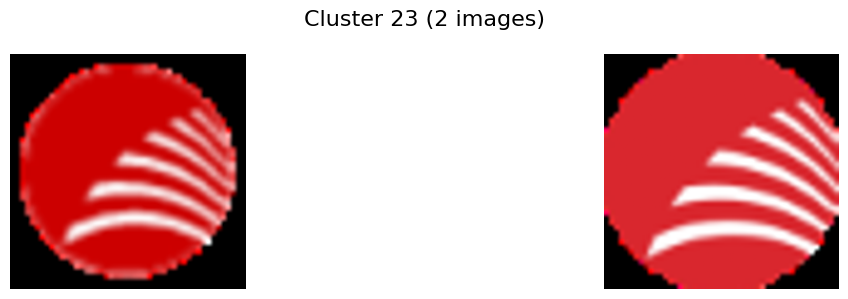

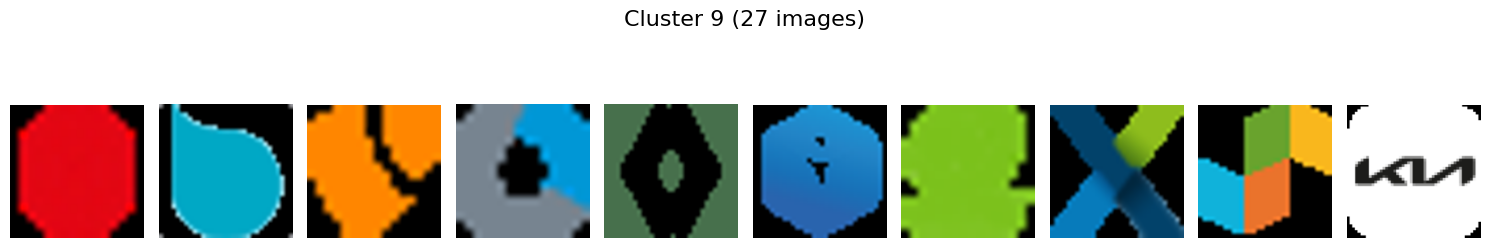

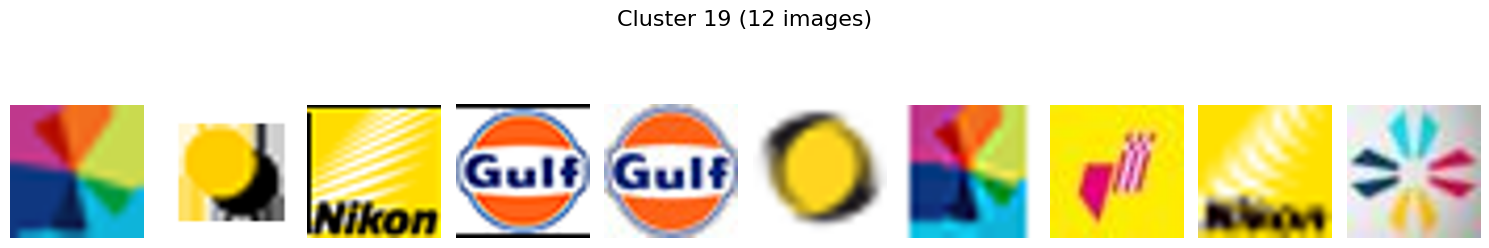

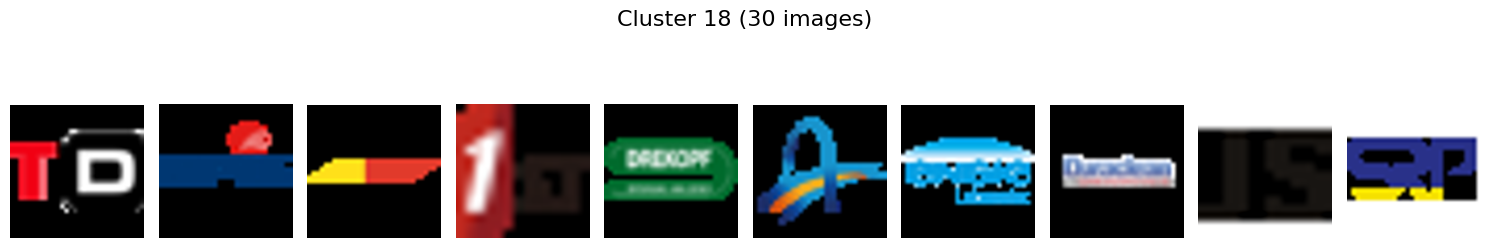

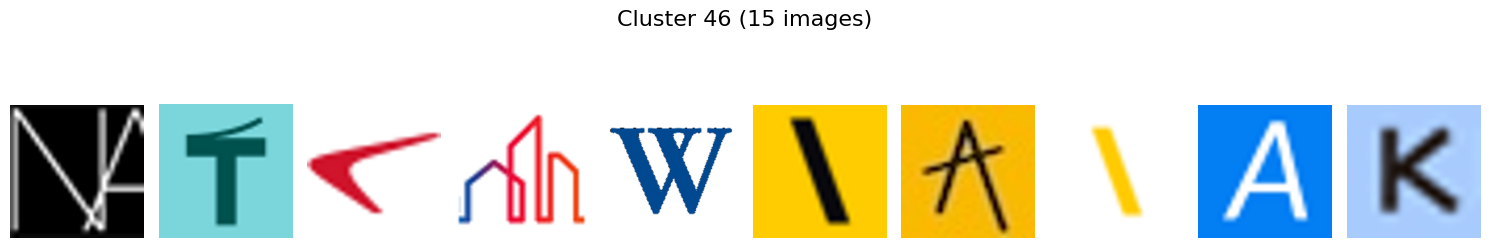

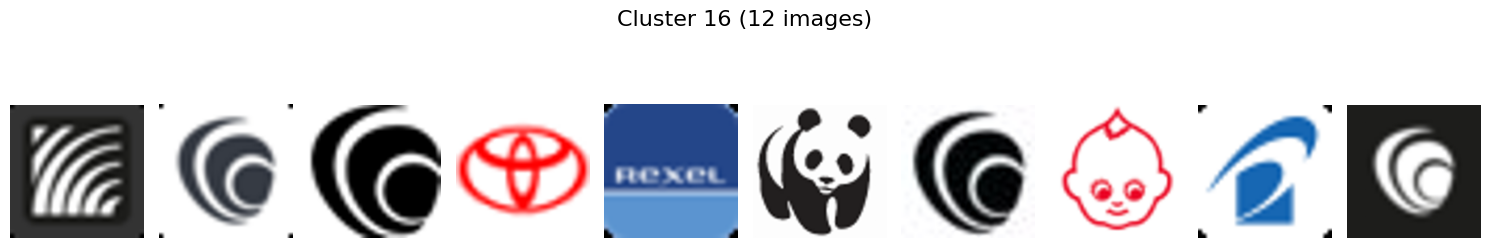

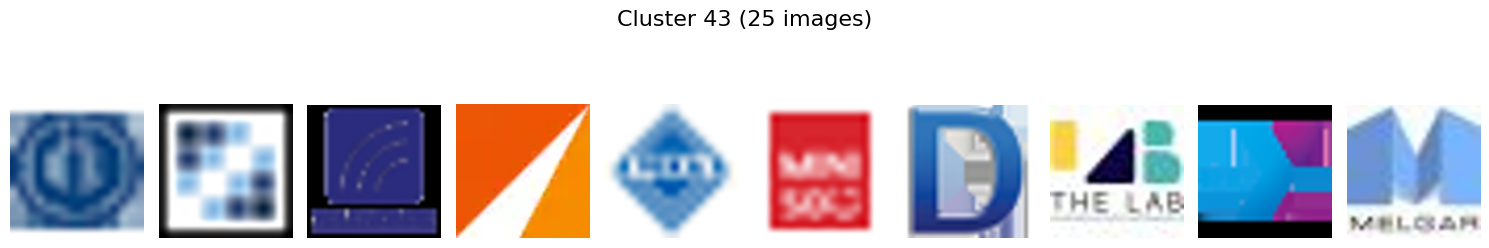

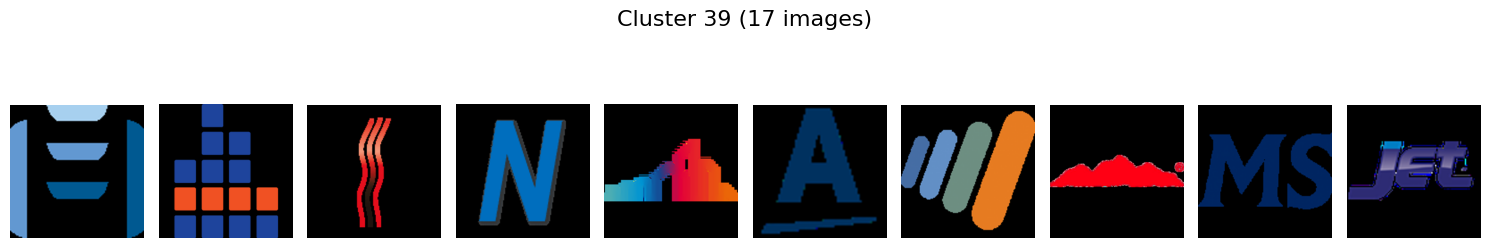

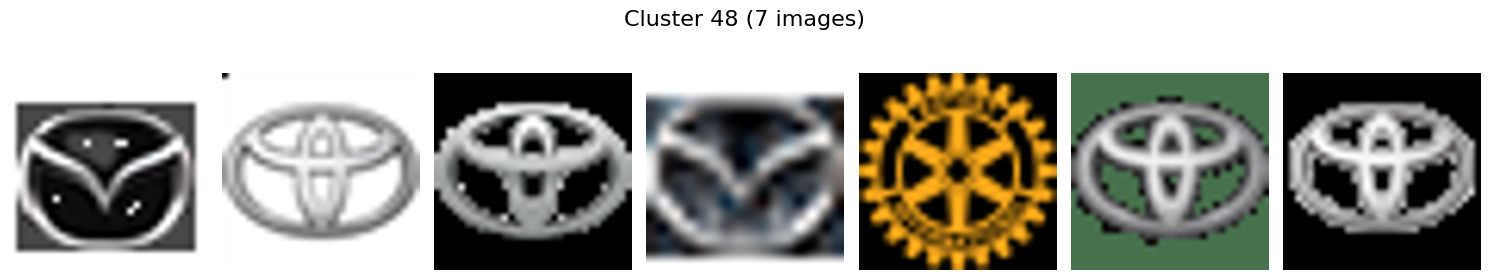

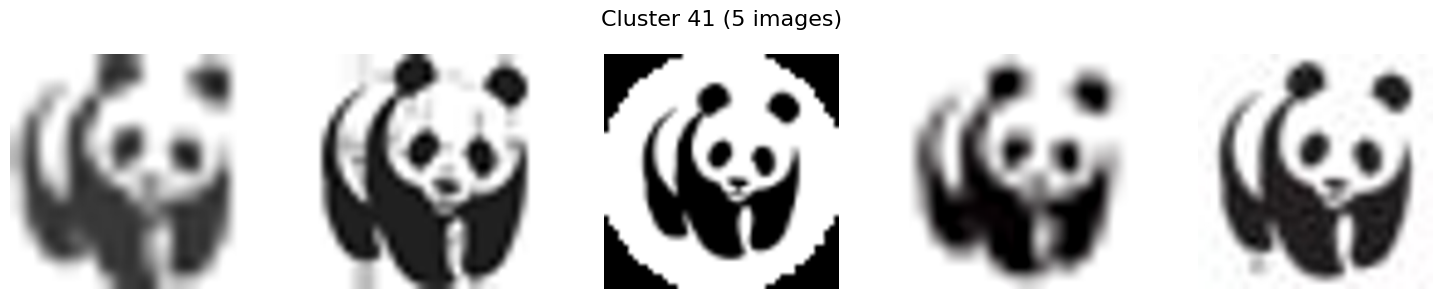

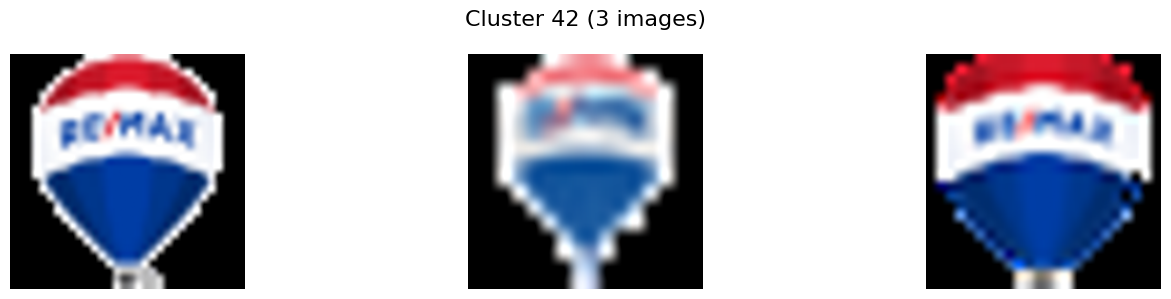

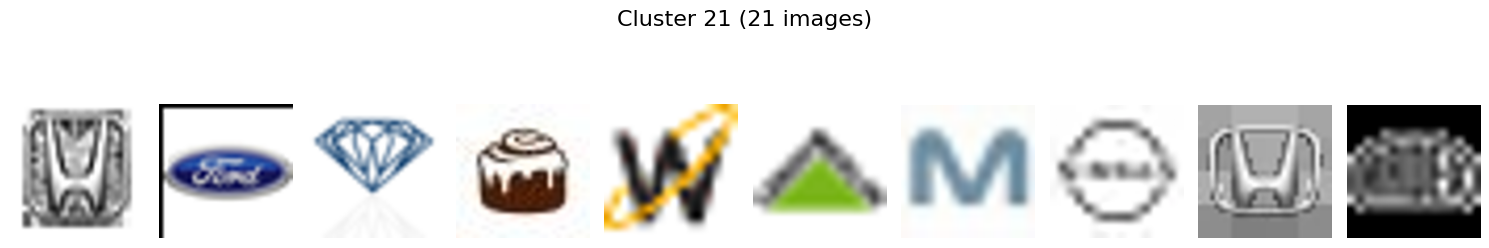

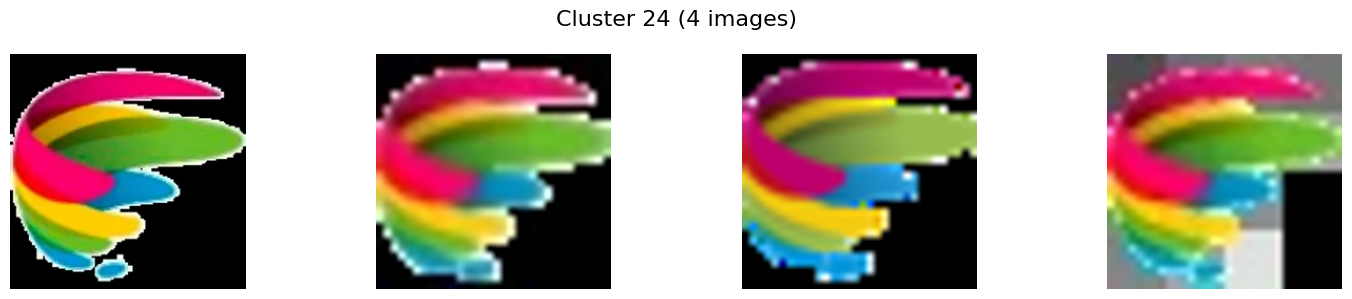

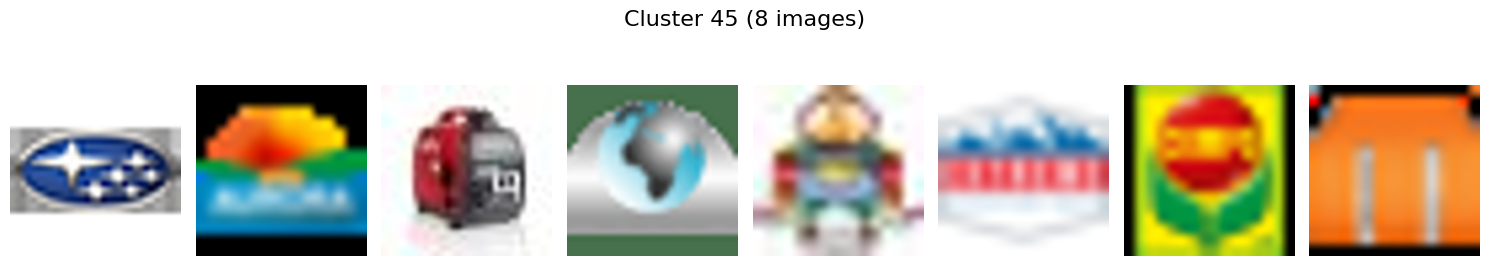

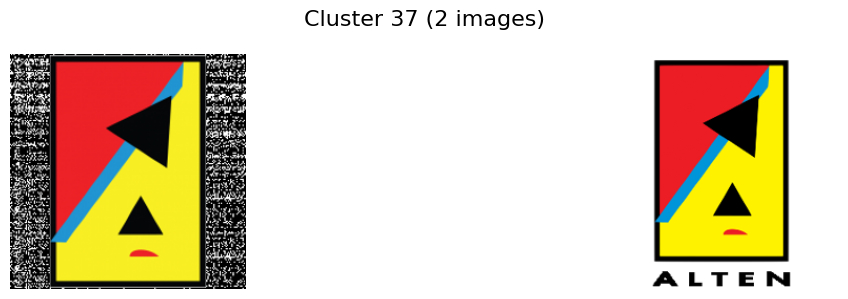

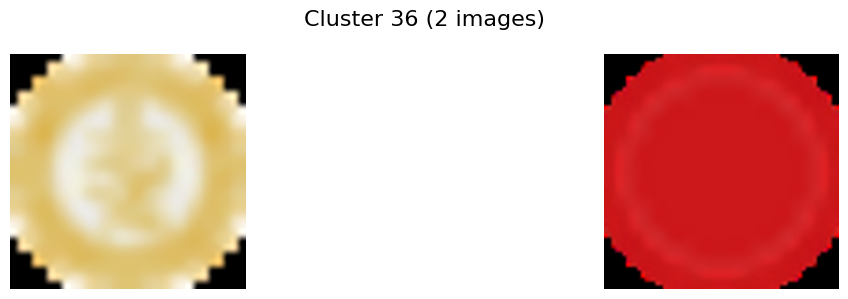

In [49]:
def visualize_kmeans_clusters(image_paths, labels, max_per_cluster=10):
    clusters = {}
    for path, label in zip(image_paths, labels):
        clusters.setdefault(label, []).append(path)

    for cluster_id, paths in clusters.items():
        plt.figure(figsize=(15, 3))
        plt.suptitle(f"Cluster {cluster_id} ({len(paths)} images)", fontsize=16)
        for i, image_path in enumerate(paths[:max_per_cluster]):
            plt.subplot(1, min(len(paths), max_per_cluster), i + 1)
            img = mpimg.imread(image_path)
            plt.imshow(img)
            plt.axis('off')
        plt.tight_layout()
        plt.show()
visualize_kmeans_clusters(unique_images, labels)


In [50]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Use the same features used for clustering
features_array = np.array(features)

# Silhouette Score
sil_score = silhouette_score(features_array, labels)
print(f"Silhouette Score: {sil_score:.4f}")

# Calinski-Harabasz Index
ch_score = calinski_harabasz_score(features_array, labels)
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

# Davies-Bouldin Index
db_score = davies_bouldin_score(features_array, labels)
print(f"Davies-Bouldin Index: {db_score:.4f}")


Silhouette Score: 0.0180
Calinski-Harabasz Index: 12.7387
Davies-Bouldin Index: 2.5851
